In [1]:
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import cesium.featurize as featurize
from collections import Counter, OrderedDict
from operator import itemgetter
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
pd.options.mode.use_inf_as_na = True

In [87]:
#Read in the metadata. 
#Read data into pandas. This metadata file has one row for each object and 8-10 columns of 
#data pertaining to object position and galaxy brightness.
# If Training set = ~ 8K rows
# If Test set = ~ 3.5M rows

metadata = pd.read_csv('training_set_metadata.csv')
metadata.head(1)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [88]:
#Load previously generated cesium feature file (see ./createFeatures.py)
featurefile = 'C:/Users/Greg/Documents/Personal/PLAsTiCC/plasticc_featuretablemore.npz'
featuretable, _ = featurize.load_featureset(featurefile)
featuretable = featuretable.reset_index(level=0)
featuretable.head()

feature index all_times_nhist_numpeaks                           \
channel                              0    1    2    3    4    5   
0         615                     18.0  3.0  3.0  3.0  3.0  4.0   
1         713                     15.0  3.0  3.0  3.0  3.0  3.0   
2         730                     16.0  7.0  7.0  7.0  7.0  7.0   
3         745                     18.0  4.0  4.0  4.0  4.0  4.0   
4        1124                     18.0  3.0  3.0  3.0  3.0  4.0   

feature all_times_nhist_peak_val                       ...           std  \
channel                        0         1         2   ...             5   
0                       0.006097  0.004050  0.004050   ...    292.182295   
1                       0.006491  0.004738  0.004738   ...      7.030448   
2                       0.006176  0.004240  0.004240   ...     13.201397   
3                       0.005318  0.004374  0.004374   ...     25.822133   
4                       0.006097  0.004050  0.004050   ...     21.245772   

feature weighted_average                                                 \
channel                0           1           2           3          4   
0             -17.061118 -212.397193 -102.220639 -101.206639 -54.744845   
1              -3.500958   -1.322397   -1.030469   -1.382941  -1.407879   
2              -0.016423   -0.034170    2.059833    2.988513   4.486335   
3               1.176322    3.652226    6.716857   12.514694  12.247387   
4               0.824380    3.617169    7.842645    8.830427   8.463856   

feature             mwebv       z    zerr  
channel          5                         
0       -59.688379  0.017  0.0000  0.0000  
1        -1.876399  0.007  1.6267  0.2552  
2         5.057690  0.021  0.2262  0.0157  
3         8.760515  0.007  0.2813  1.1523  
4         5.602845  0.024  0.2415  0.0176  

[5 rows x 130 columns]

In [89]:
#Flatten index of the column names by changing the passband indicators to astronomical labels, and merging those labels with
#the feature name
old_names = featuretable.columns.values
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])
pbnames = list(pbmap.values())
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]

featuretable.columns = featuretable.columns.droplevel(0)
featuretable.columns = new_names
featuretable.head()

,index_meta,all_times_nhist_numpeaks_u,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_i,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,all_times_nhist_peak_val_u,all_times_nhist_peak_val_g,all_times_nhist_peak_val_r,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
0,615,18.0,3.0,3.0,3.0,3.0,4.0,0.006097,0.004050,0.004050,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,713,15.0,3.0,3.0,3.0,3.0,3.0,0.006491,0.004738,0.004738,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,730,16.0,7.0,7.0,7.0,7.0,7.0,0.006176,0.004240,0.004240,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,745,18.0,4.0,4.0,4.0,4.0,4.0,0.005318,0.004374,0.004374,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,1124,18.0,3.0,3.0,3.0,3.0,4.0,0.006097,0.004050,0.004050,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


In [90]:
#Rename the object Id column in the feature table to enable a merge with the metadataa
featuretable = featuretable.rename(columns={"index_meta":"object_id"})
featuretable['object_id'] = featuretable.object_id.astype('int32')

#This should have over a hundred rows (all our features), plus metadata. one row for each galactic object.
df = pd.merge(metadata,featuretable, on="object_id")
df.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


In [ ]:
#now all our data is in a single dataframe, and we can delete the pieces from memory
del featuretable, metadata

In [92]:
#Filter to only galactic objects, which is the goal of this model
#per the code book, galactic objects have hostgal_specz == 0
egalmask = df['hostgal_specz'] != 0
gal = df[~egalmask]
display(gal.shape)
#let's see our class imbalance
gal.groupby('target').agg('count')

(2325, 141)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
target,,,,,,,,,,,,,,,,,,,,,
6,151,151,151,151,151,151,151,151,151,0,...,151,151,151,151,151,151,151,151,151,151
16,924,924,924,924,924,924,924,924,924,0,...,924,924,924,924,924,924,924,924,924,924
53,30,30,30,30,30,30,30,30,30,0,...,30,30,30,30,30,30,30,30,30,30
65,981,981,981,981,981,981,981,981,981,0,...,981,981,981,981,981,981,981,981,981,981
92,239,239,239,239,239,239,239,239,239,0,...,239,239,239,239,239,239,239,239,239,239


In [93]:
#Our classes are imbalanced and we'll need to Create SMOTE object
sm = SMOTE(sampling_strategy='not majority')

#Drop cols I don't want to generate with SMOTE. 
#Things like position in the sky or object_Id are meaningless to simulate with SMOTE
Y = gal['target']
gal = gal.drop(['object_id','target', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf'], axis=1) #remove 'target' if using test data

#drop any columns with nans. occasionally the cesium features can't compute, and we have plenty so losing a few is no problem.
nans = pd.DataFrame(gal.isnull().sum(axis=0), columns=['na'])
X = gal.drop([x for x in nans[nans.na>0].index.values],axis=1)

display(X.shape)
Y.shape

(2325, 114)

(2325,)

In [94]:
#Confirm no NaNs
nans = pd.DataFrame(X.isnull().sum(axis=0), columns=['na'])
nans[nans.na>0]

,na


In [95]:
#Create extra samples and check how many were created
X_new, Y_new = sm.fit_resample(X,Y)
display(X_new.shape)

(4905, 114)

In [96]:
#Re-add target and confirm balance
df = pd.DataFrame(X_new, columns=X.columns)
df['target'] = Y_new
df.groupby('target').agg('count')

,hostgal_specz,hostgal_photoz,hostgal_photoz_err,mwebv,all_times_nhist_numpeaks_u,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_i,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
target,,,,,,,,,,,,,,,,,,,,,
6,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
16,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
53,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
65,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981
92,981,981,981,981,981,981,981,981,981,981,...,981,981,981,981,981,981,981,981,981,981


In [145]:
#I picked these by eyeballing boxplot charts for arbitrarily significant differences between classes. 
#I'll use PCA to combine instances where the same measurements in different passbands provide similar information.
galatts = df[['all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y', 'amplitude_u', 'amplitude_Y', 'amplitude_g',
                    'percent_beyond_1_std_r', 'percent_beyond_1_std_i', 'percent_beyond_1_std_z', 'percent_beyond_1_std_Y',
                    'maximum_u', 'maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y','max_slope_g', 'max_slope_r', 'max_slope_z',
                     'max_slope_Y', 'median_i', 'median_z', 'median_Y', 'median_absolute_deviation_g', 'median_absolute_deviation_z',
                    'median_absolute_deviation_Y', 'percent_close_to_median_g', 'percent_close_to_median_Y', 'period_fast_g',
                     'period_fast_r', 'period_fast_i', 'period_fast_z', 'period_fast_Y', 'qso_log_chi2_qsonu_u', 
                    'qso_log_chi2_qsonu_g', 'qso_log_chi2_qsonu_r', 'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_z', 
                    'qso_log_chi2_qsonu_Y', 'freq1_freq_r', 'minimum_g', 'minimum_r', 'minimum_i', 'minimum_z', 'minimum_Y',
                    'skew_g', 'skew_r', 'skew_i', 'skew_z', 'skew_Y', 'std_g', 'std_i', 'std_z', 'std_Y']]
galatts.head()

,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,amplitude_u,amplitude_Y,amplitude_g,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_Y,maximum_u,...,minimum_Y,skew_g,skew_r,skew_i,skew_z,skew_Y,std_g,std_i,std_z,std_Y
0,3.0,4.0,121.048015,400.501617,880.533203,0.568966,0.551724,0.517241,0.596491,125.182808,...,-422.815094,0.404755,0.331063,0.285492,0.194883,0.121948,596.576924,332.520885,289.276965,292.182295
1,7.0,7.0,37.748134,15.231738,5.337230,0.326923,0.423077,0.215686,0.352941,71.678154,...,-12.695161,1.980310,0.017738,-0.042035,0.240085,0.519950,1.678401,1.605822,3.563588,5.538789
2,5.0,5.0,7.112926,34.185699,3.576050,0.044444,0.400000,0.400000,0.377778,7.164557,...,-52.764721,-0.042038,4.202053,-0.457403,-0.147721,-1.439236,1.537419,2.520093,4.068033,12.243557
3,3.0,4.0,52.562683,228.430742,26.946058,0.034483,0.034483,0.017241,0.017544,98.330528,...,-24.442568,4.732014,6.687818,6.510663,7.410255,6.699774,6.149013,19.455325,246.982624,58.563573
4,3.0,3.0,8.887536,46.442033,92.284029,0.107143,0.107143,0.125000,0.125000,9.575159,...,-63.193478,-3.296874,-3.513109,-3.271743,-3.171328,-2.124661,22.862074,30.551600,21.272436,12.168863


# Examine cases where I kept the same feature for multiple passbands. if there correllations are high enough, use PCA to combine their information.

In [146]:
#this dataframe will hold the features/components ultimately used in the model
galfeats = pd.DataFrame(index=galatts.index)

In [147]:
numpeaks = galatts[['all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y']]
X = StandardScaler().fit_transform(numpeaks)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

#91% explained by the best component
P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)


#drop the columns I no longer need
galatts = galatts.drop(['all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y'],axis=1)

#Store the component in our feature df
galfeats['numpeaks'] = Y

galfeats.head()

%Variance explained by each component
 [0.09191773 0.90808227]


,numpeaks
0,3.062073
1,1.960896
2,2.587865
3,3.062073
4,3.214834


--------

In [148]:
####################################
amp = galatts[['amplitude_u', 'amplitude_Y', 'amplitude_g']]
amp.corr()
#combine Y and G passbands, leave u on its own

,amplitude_u,amplitude_Y,amplitude_g
amplitude_u,1.000000,0.002386,0.198337
amplitude_Y,0.002386,1.000000,0.474408
amplitude_g,0.198337,0.474408,1.000000


In [149]:
amp = amp[['amplitude_Y', 'amplitude_g']]
X = StandardScaler().fit_transform(amp)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.26279584 0.73720416]


In [150]:
#84% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galfeats['amp_g_Y'] = Y

#I need to scale u, since I'm ultimately building a KNN. I'll need to rewrite this for test data so 
#that the scaler is stored.
galfeats['amplitude_u'] = StandardScaler().fit_transform(pd.DataFrame(galatts['amplitude_u']))
galatts = galatts.drop(['amplitude_Y', 'amplitude_g', 'amplitude_u'],axis=1)




galfeats.describe()

,numpeaks,amplitude_u,amp_g_Y
count,4.905000e+03,4.905000e+03,4.905000e+03
mean,1.008811e-14,-7.243045e-19,-2.491608e-16
std,1.347789e+00,1.000102e+00,7.250509e-01
min,-2.243270e+00,-3.744891e-02,-4.725397e+00
25%,-8.604629e-01,-3.687756e-02,-4.731094e-02
50%,-4.241709e-01,-3.605863e-02,-2.525307e-02
75%,1.258693e-01,-3.133938e-02,9.752672e-02
max,3.214834e+00,5.064908e+01,6.196717e+00


--------

In [151]:
pctbey = galatts[['percent_beyond_1_std_r', 'percent_beyond_1_std_i', 'percent_beyond_1_std_z', 'percent_beyond_1_std_Y']]
pctbey.corr()
#HMM. not sure what to do here, recheck the charts to see if they indicate similar classes or not

,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_Y
percent_beyond_1_std_r,1.000000,0.738002,0.650873,0.573127
percent_beyond_1_std_i,0.738002,1.000000,0.753249,0.700512
percent_beyond_1_std_z,0.650873,0.753249,1.000000,0.808571
percent_beyond_1_std_Y,0.573127,0.700512,0.808571,1.000000


In [152]:
X = StandardScaler().fit_transform(pctbey)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.77892595 0.11838067 0.05718634 0.04550704]


In [153]:
#65% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['percent_beyond_1_std_r', 'percent_beyond_1_std_i', 'percent_beyond_1_std_z', 'percent_beyond_1_std_Y'],axis=1)
galfeats['pct_beyond_1_std'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std
0,3.062073,-0.034062,0.152107,-2.048942
1,1.960896,-0.036420,-0.026650,0.176758
2,2.587865,-0.037287,-0.028072,0.348891
3,3.062073,-0.036000,-0.033210,3.152751
4,3.214834,-0.037236,-0.008511,2.267986


--------

In [154]:
maxes = galatts[['maximum_u', 'maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y',]]
maxes.corr()


,maximum_u,maximum_g,maximum_r,maximum_z,maximum_Y
maximum_u,1.000000,0.086827,0.022048,0.006535,0.005216
maximum_g,0.086827,1.000000,0.886056,0.693477,0.667308
maximum_r,0.022048,0.886056,1.000000,0.793138,0.764521
maximum_z,0.006535,0.693477,0.793138,1.000000,0.983114
maximum_Y,0.005216,0.667308,0.764521,0.983114,1.000000


In [155]:
#Leave u as is, combine g, r, z, and Y
galfeats['maximum_u'] = StandardScaler().fit_transform(pd.DataFrame(galatts['maximum_u']))

maxes = galatts[['maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y',]]

In [156]:
X = StandardScaler().fit_transform(maxes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.84906166 0.12195944 0.02503628 0.00394262]


In [157]:
#92% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['maximum_u','maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y'],axis=1)
galfeats['max_grzY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301


--------

In [158]:
maxslopes = galatts[['max_slope_g', 'max_slope_r', 'max_slope_z', 'max_slope_Y']]
maxslopes.corr()

,max_slope_g,max_slope_r,max_slope_z,max_slope_Y
max_slope_g,1.000000,0.253778,0.125970,0.258230
max_slope_r,0.253778,1.000000,0.213276,0.522321
max_slope_z,0.125970,0.213276,1.000000,0.447426
max_slope_Y,0.258230,0.522321,0.447426,1.000000


In [159]:
maxslopes = galatts[['max_slope_g', 'max_slope_r', 'max_slope_z', 'max_slope_Y']]
X = StandardScaler().fit_transform(maxslopes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.48760843 0.22528236 0.18509576 0.10201345]


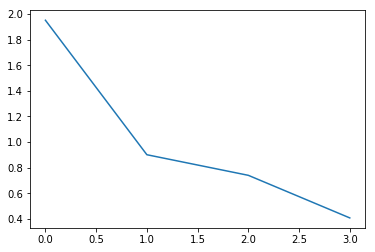

array([1.95083145, 0.90131319, 0.74053403, 0.408137  ])

In [160]:
plt.plot(eig_val_cov)
plt.show()
eig_val_cov

In [161]:
#This is tough, but the 2nd component is just falling under most rules-of-thumb, so I'll just keep the 1.
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['max_slope_g', 'max_slope_r', 'max_slope_z', 'max_slope_Y'],axis=1)
galfeats['maxslope_grzY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171


--------

In [162]:
medians = galatts[['median_i', 'median_z', 'median_Y']]
medians.corr()

,median_i,median_z,median_Y
median_i,1.000000,0.953998,0.922478
median_z,0.953998,1.000000,0.984513
median_Y,0.922478,0.984513,1.000000


In [163]:

X = StandardScaler().fit_transform(medians)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.96918335 0.02734814 0.00346852]


In [164]:
#Love the easy ones
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['median_i', 'median_z', 'median_Y'],axis=1)
galfeats['median_izY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603


---------------------

In [165]:
medabsdev = galatts[['median_absolute_deviation_g', 'median_absolute_deviation_z','median_absolute_deviation_Y']]
medabsdev.corr()

,median_absolute_deviation_g,median_absolute_deviation_z,median_absolute_deviation_Y
median_absolute_deviation_g,1.00000,0.207680,0.128710
median_absolute_deviation_z,0.20768,1.000000,0.958227
median_absolute_deviation_Y,0.12871,0.958227,1.000000


In [166]:
X = StandardScaler().fit_transform(medabsdev)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.67136884 0.31582193 0.01280923]


In [167]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['median_absolute_deviation_g', 'median_absolute_deviation_z','median_absolute_deviation_Y'],axis=1)
galfeats['medabsdev_gzY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682


---------------------

In [168]:
medianpct = galatts[['percent_close_to_median_g', 'percent_close_to_median_Y']]
medianpct.corr()

,percent_close_to_median_g,percent_close_to_median_Y
percent_close_to_median_g,1.000000,0.434177
percent_close_to_median_Y,0.434177,1.000000


In [169]:
X = StandardScaler().fit_transform(medianpct)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.7170883 0.2829117]


In [170]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['percent_close_to_median_g', 'percent_close_to_median_Y'],axis=1)
galfeats['medianpct_gY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355


---------------------

In [171]:
periodfast = galatts[['period_fast_g', 'period_fast_r', 'period_fast_i', 'period_fast_z','period_fast_Y']]
periodfast.corr()

,period_fast_g,period_fast_r,period_fast_i,period_fast_z,period_fast_Y
period_fast_g,1.000000,0.384511,0.360937,0.370953,0.304984
period_fast_r,0.384511,1.000000,0.449165,0.477412,0.437861
period_fast_i,0.360937,0.449165,1.000000,0.445753,0.438681
period_fast_z,0.370953,0.477412,0.445753,1.000000,0.527571
period_fast_Y,0.304984,0.437861,0.438681,0.527571,1.000000


In [172]:
X = StandardScaler().fit_transform(periodfast)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.53767965 0.14495798 0.09255546 0.10918109 0.11562581]


array([2.68894648, 0.72493772, 0.46287168, 0.54601677, 0.57824693])

In [173]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['period_fast_g', 'period_fast_r', 'period_fast_i', 'period_fast_z','period_fast_Y'],axis=1)
galfeats['periodfast_grizY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150,-0.006179
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753,0.685462
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376,2.033062
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286,0.141344
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355,2.283440


---------------

In [174]:
qlcq = galatts[['qso_log_chi2_qsonu_u', 'qso_log_chi2_qsonu_g','qso_log_chi2_qsonu_r', 
                'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_z','qso_log_chi2_qsonu_Y']]
qlcq.corr()

,qso_log_chi2_qsonu_u,qso_log_chi2_qsonu_g,qso_log_chi2_qsonu_r,qso_log_chi2_qsonu_i,qso_log_chi2_qsonu_z,qso_log_chi2_qsonu_Y
qso_log_chi2_qsonu_u,1.000000,0.576401,0.538803,0.485577,0.439868,0.389128
qso_log_chi2_qsonu_g,0.576401,1.000000,0.836887,0.811761,0.762642,0.710952
qso_log_chi2_qsonu_r,0.538803,0.836887,1.000000,0.845807,0.821200,0.775644
qso_log_chi2_qsonu_i,0.485577,0.811761,0.845807,1.000000,0.906677,0.872978
qso_log_chi2_qsonu_z,0.439868,0.762642,0.821200,0.906677,1.000000,0.935218
qso_log_chi2_qsonu_Y,0.389128,0.710952,0.775644,0.872978,0.935218,1.000000


In [175]:
X = StandardScaler().fit_transform(qlcq)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.77307901 0.12451145 0.04937429 0.02563913 0.00971    0.01768613]


array([4.63941991, 0.74722106, 0.29630612, 0.15386614, 0.05827187,
       0.10613839])

In [176]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['qso_log_chi2_qsonu_u', 'qso_log_chi2_qsonu_g','qso_log_chi2_qsonu_r', 
                'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_z','qso_log_chi2_qsonu_Y'],axis=1)
galfeats['qlcq_ugrizY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150,-0.006179,-3.522100
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753,0.685462,2.906115
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376,2.033062,2.828103
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286,0.141344,0.664141
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355,2.283440,0.533983


---------------

In [177]:
galfeats['freq1_freq_r'] = StandardScaler().fit_transform(pd.DataFrame(galatts['freq1_freq_r']))
galatts = galatts.drop(['freq1_freq_r'], axis=1)
galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150,-0.006179,-3.522100,-1.032633
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753,0.685462,2.906115,1.487620
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376,2.033062,2.828103,0.420054
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286,0.141344,0.664141,0.232607
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355,2.283440,0.533983,-1.173416


---------------

In [178]:
mins = galatts[['minimum_g', 'minimum_r', 'minimum_i', 'minimum_z', 'minimum_Y']]
mins.corr()

,minimum_g,minimum_r,minimum_i,minimum_z,minimum_Y
minimum_g,1.000000,0.829923,0.373512,0.172267,0.103382
minimum_r,0.829923,1.000000,0.543734,0.323085,0.233988
minimum_i,0.373512,0.543734,1.000000,0.944036,0.887260
minimum_z,0.172267,0.323085,0.944036,1.000000,0.986095
minimum_Y,0.103382,0.233988,0.887260,0.986095,1.000000


In [179]:
X = StandardScaler().fit_transform(mins)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [6.50663008e-01 3.05592071e-01 3.29474092e-02 1.02463069e-02
 5.51205165e-04]


array([3.25397844e+00, 1.52827193e+00, 1.64770638e-01, 5.12419816e-02,
       2.75658782e-03])

In [180]:
#I'll keep 2, in this case
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['min_grizY_1'] = Y

P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)
galfeats['min_grizY_2'] = Y


galatts = galatts.drop(['minimum_g', 'minimum_r', 'minimum_i', 'minimum_z', 'minimum_Y'],axis=1)


galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r,min_grizY_1,min_grizY_2
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150,-0.006179,-3.522100,-1.032633,0.452084,-0.266257
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753,0.685462,2.906115,1.487620,0.898449,0.315804
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376,2.033062,2.828103,0.420054,0.896016,0.317008
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286,0.141344,0.664141,0.232607,0.894995,0.311792
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355,2.283440,0.533983,-1.173416,0.793083,0.206824


---------------

In [181]:
skews = galatts[['skew_g', 'skew_r', 'skew_i', 'skew_z', 'skew_Y']]
skews.corr()

,skew_g,skew_r,skew_i,skew_z,skew_Y
skew_g,1.000000,0.758189,0.739182,0.629431,0.523794
skew_r,0.758189,1.000000,0.731311,0.667828,0.561542
skew_i,0.739182,0.731311,1.000000,0.722127,0.608608
skew_z,0.629431,0.667828,0.722127,1.000000,0.663969
skew_Y,0.523794,0.561542,0.608608,0.663969,1.000000


In [182]:
X = StandardScaler().fit_transform(skews)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.72990224 0.11076988 0.06292081 0.04517177 0.05123529]


array([3.65025541, 0.55396236, 0.31466822, 0.22590489, 0.25622869])

In [183]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['skew_grizY'] = Y

galatts = galatts.drop(['skew_g', 'skew_r', 'skew_i', 'skew_z', 'skew_Y'],axis=1)


galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r,min_grizY_1,min_grizY_2,skew_grizY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150,-0.006179,-3.522100,-1.032633,0.452084,-0.266257,-0.733037
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753,0.685462,2.906115,1.487620,0.898449,0.315804,-0.383214
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376,2.033062,2.828103,0.420054,0.896016,0.317008,-0.634481
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286,0.141344,0.664141,0.232607,0.894995,0.311792,6.350036
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355,2.283440,0.533983,-1.173416,0.793083,0.206824,-4.606848


---------------

In [184]:
stds = galatts[['std_g', 'std_i', 'std_z', 'std_Y']]
stds.corr()

,std_g,std_i,std_z,std_Y
std_g,1.000000,0.772793,0.608904,0.569352
std_i,0.772793,1.000000,0.931051,0.910553
std_z,0.608904,0.931051,1.000000,0.979893
std_Y,0.569352,0.910553,0.979893,1.000000


In [185]:
X = StandardScaler().fit_transform(stds)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.85212591 0.13135287 0.01194329 0.00457793]


array([3.40919869, 0.52551861, 0.04778291, 0.01831544])

In [186]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['std_gizY'] = Y

#PCA done, all features created.
del galatts

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r,min_grizY_1,min_grizY_2,skew_grizY,std_gizY
0,3.062073,-0.034062,0.152107,-2.048942,-0.033971,0.506310,-0.448188,-0.145581,-0.446661,-2.008150,-0.006179,-3.522100,-1.032633,0.452084,-0.266257,-0.733037,0.542811
1,1.960896,-0.036420,-0.026650,0.176758,-0.035088,0.608906,-0.673687,-0.187966,-0.697020,0.019753,0.685462,2.906115,1.487620,0.898449,0.315804,-0.383214,0.729790
2,2.587865,-0.037287,-0.028072,0.348891,-0.036434,0.608240,-0.670902,-0.188007,-0.695875,-0.114376,2.033062,2.828103,0.420054,0.896016,0.317008,-0.634481,0.729260
3,3.062073,-0.036000,-0.033210,3.152751,-0.034531,0.542559,-0.657229,-0.187833,-0.694991,2.589286,0.141344,0.664141,0.232607,0.894995,0.311792,6.350036,0.702958
4,3.214834,-0.037236,-0.008511,2.267986,-0.036384,0.601301,-0.651171,-0.187603,-0.694682,1.669355,2.283440,0.533983,-1.173416,0.793083,0.206824,-4.606848,0.721012


In [187]:
galfeats.shape

(4905, 17)

In [190]:
#Split X,Y
galX = galfeats
galY = df['target']


#Create Train/Test splits
galX_train, galX_test, galY_train, galY_test = train_test_split(
    galX, galY, test_size=0.5)

#test a KNN
galknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
galknn.fit(galX_train, galY_train)

galknn.score(galX_test, galY_test)

0.940481043620057

In [195]:
#This is just so I can confirm that the matrix is labelling classes correctly
counts = Counter(df['target'])
galLabels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

srt = sorted(galLabels)
counts

Counter({92: 981, 65: 981, 16: 981, 6: 981, 53: 981})

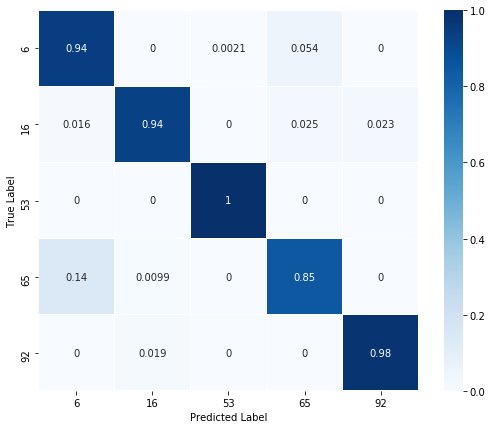

In [199]:
galY_pred = galknn.predict(galX_test)

cm = confusion_matrix(galY_test, galY_pred,labels = srt)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, yticklabels=srt,xticklabels=srt, cmap='Blues',annot = True, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [203]:
scores = cross_val_score(galknn,galX,galY, cv=10)
display(scores)
scores.mean()

array([0.98383838, 0.97959184, 0.97959184, 0.93877551, 0.94285714,
       0.94693878, 0.94285714, 0.93469388, 0.95918367, 0.94897959])

0.9557307771593486